In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

from causalml.inference.meta import BaseSClassifier, BaseTClassifier, \
    BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier, \
    uplift_tree_string, uplift_tree_plot
from catboost import CatBoostClassifier, CatBoostRegressor


In [14]:
# Возьмем функцию для оценки qini-curve с прошлого занятия
def qini_df(df, title='train', figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['treatment'] == 0)
    N_t = sum(ranked['treatment'] == 1)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[(ranked.treatment == 0) & (ranked.conversion==1),'n_c1'] = 1
    ranked.loc[(ranked.treatment == 1) & (ranked.conversion==1),'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    
    # Немного кода для визуализации
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini score: {:.3f}'.format(quni_score))

## 1. Импорт и  первичный анализ данных

In [15]:
data = pd.read_csv('data/criteo-uplift-v2.1.csv')
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [17]:
data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


**Fields:**  

*f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11*: feature values (dense, float)  
*treatment*: treatment group (1 = treated, 0 = control)  
*conversion*: whether a conversion occured for this user (binary, label)  
*visit*: whether a visit occured for this user (binary, label)  
*exposure*: treatment effect, whether the user has been effectively exposed (binary)  

Проверим данные на пропуски.

In [18]:
data.isna().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

Оценим сбалансированность выборки.

In [19]:
data.treatment.value_counts()

treatment
1    11882655
0     2096937
Name: count, dtype: int64

Предварительно оценим эффективность возействия. Также хочется понять, что такое exposure.

In [20]:
data[['treatment', 'exposure', 'conversion', 'visit']].value_counts()

treatment  exposure  conversion  visit
1          0         0           0        11055129
0          0         0           0         2016832
1          0         0           1          385634
           1         0           0          250702
                                 1          154479
0          0         0           1           76042
1          1         1           1           23031
           0         1           1           13680
0          0         1           1            4063
Name: count, dtype: int64

In [21]:
data[['treatment', 'conversion', 'visit', 'exposure']].pivot_table(index=['treatment', 'exposure'], aggfunc='sum')

conversion   visit
treatment exposure                    
0         0               4063   80105
1         0              13680  399314
          1              23031  177510

Судя по всему exposure это оценка качества воздействия. Предлагаю использовать параметр воздействия столбец treatment, а как целевую переменнцую conversion.

## 2. Построение обучающего, валидационного и тестового датасета

In [22]:
target = 'conversion'
treatmen = 'treatment'
feature = ['f'+ str(n) for n in range(12)]

In [23]:
data_train, data_val_test = train_test_split(
    data, 
    stratify=data[[target, treatmen]], 
    random_state=42, 
    test_size=0.4
)

data_val, data_test = train_test_split(
    data_val_test, 
    stratify=data_val_test[[target, treatmen]], 
    random_state=42, 
    test_size=0.5
)

print('train shape:', data_train.shape)
print('validation shape:', data_val.shape)
print('test shape:', data_test.shape)

data_train.head()

train shape: (8387755, 16)
validation shape: (2795918, 16)
test shape: (2795919, 16)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
419751,26.719153,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
927921,13.996611,10.679513,8.297545,-3.593018,11.029584,3.013064,-16.660707,7.606718,3.856829,34.404217,5.887674,-0.267350,1,0,0,1
10960144,26.189158,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
11017526,25.000695,10.059654,8.295708,4.679882,10.280525,4.115453,-7.301017,4.833815,3.759910,41.352674,5.300375,-0.168679,1,0,1,0
9687777,12.616365,10.059654,8.769772,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


## 3. Построение S-learner. Оцененка качества с помощью qini curve.

In [24]:
# Создадим базовый S-learner
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=42, verbose=0))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
s_learner.fit(X=data_train[feature],
              treatment=data_train[treatmen],
              y=data_train[target])

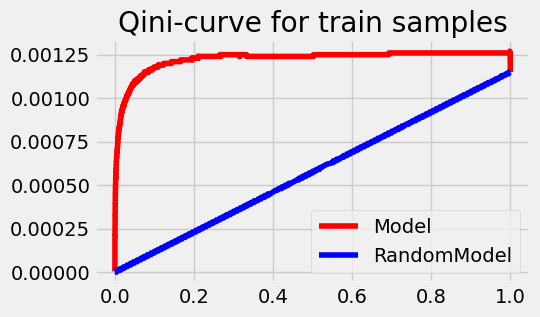

Qini score: 5444.138


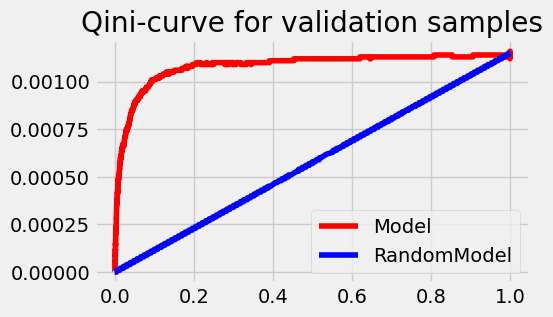

Qini score: 1414.886


In [37]:
# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(np.array(data_train[feature].values.copy()))
data_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на валидационной выборке
uplift_vals = s_learner.predict(np.array(data_val[feature].values.copy()))
data_val['uplift_score'] = uplift_vals


# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(data_train, title='train')
qini_df(data_val, title='validation')

**Вывод:** Судя по графикам модель не переобучена. Предлагаю использовать как базу для оценки остальных моделей.

## 4. Построение T-learner. Оцененка качества с помощью qini curve.

In [26]:
# Создадим базовый T-learner
t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=42, verbose=0))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
t_learner.fit(X=data_train[feature],
              treatment=data_train[treatmen],
              y=data_train[target])

c:\Projects\DS\lessons\.venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


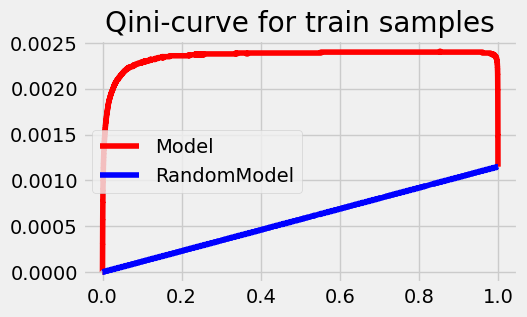

Qini score: 14907.557


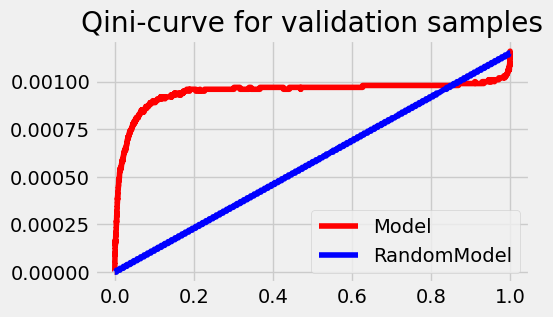

Qini score: 1038.001


In [38]:
# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = t_learner.predict(np.array(data_train[feature].values.copy()))
data_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на валидационной выборке
uplift_vals = t_learner.predict(np.array(data_val[feature].values.copy()))
data_val['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(data_train, title='train')
qini_df(data_val, title='validation')

**Вывод:** Результаты T-learner несколько хуже чем у S-learner. Судя по графику модель переобучена. Возможно имеет смысл применить более простую модель для обучения. 

## 5. Построение X-learner. Оцененка качества с помощью qini curve.

In [28]:
# Создадим базовый X-learner
x_learner = BaseXClassifier(
    outcome_learner=CatBoostClassifier(depth=5, random_seed=42, verbose=0),
    effect_learner=LinearRegression()
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
uplift_vals = x_learner.fit(
    X=data_train[feature],
    treatment=data_train[treatmen],
    y=data_train[target],
)


c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: Convergen

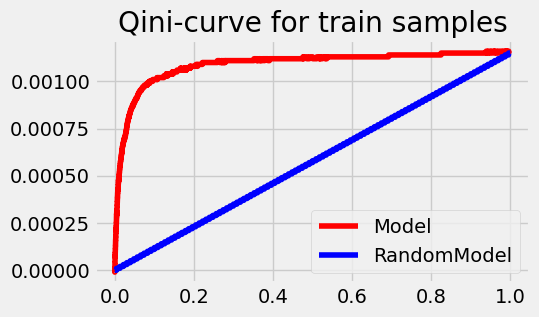

Qini score: 4309.686


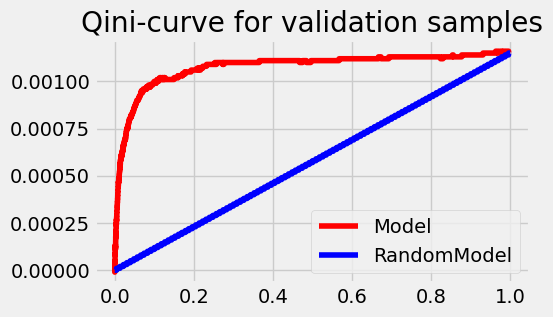

Qini score: 1400.129


In [39]:
# Сделаем предсказание uplift-эффекта на обучающей выборке
# так как без коэфициента метод predict не работает, создаем коэфициент
p=np.array([0.5 for i in range(len(data_train[feature]))])
uplift_vals = x_learner.predict(np.array(data_train[feature].values.copy()), p=p)
data_train['uplift_score'] = uplift_vals

# # Сделаем предсказание uplift-эффекта на валидационной выборке
p=np.array([0.5 for i in range(len(data_val[feature]))])
uplift_vals = x_learner.predict(np.array(data_val[feature].values.copy()), p=p)
data_val['uplift_score'] = uplift_vals

# # Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(data_train, title='train')
qini_df(data_val, title='validation')

**Вывод:**  Результаты X-learner немного лучше, чем у S-learner. Не наблюдается переобучение. Пока можно считать наилучшей моделью.

## 6. Построение R-learner. Оцененка качества с помощью qini curve.

c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Projects\DS\lessons\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:349: Convergen

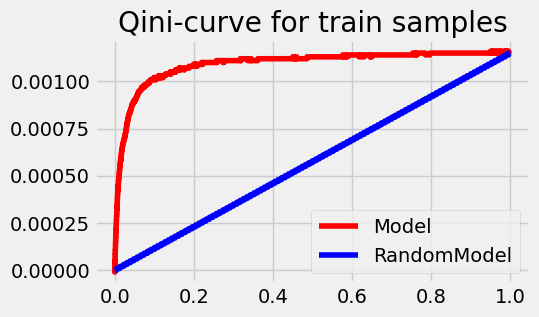

Qini score: 4333.521


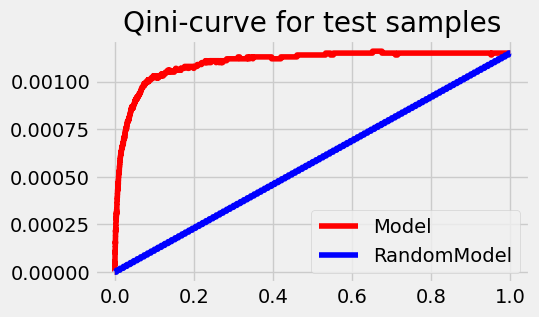

Qini score: 1463.330


In [ ]:
# Создадим базовый R-learner
r_learner = BaseRClassifier(
    outcome_learner=CatBoostClassifier(depth=5, random_seed=42, verbose=0),
    effect_learner=LinearRegression(),
    random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
r_learner.fit(X=data_train[feature],
              treatment=data_train[treatmen],
              y=data_train[target])

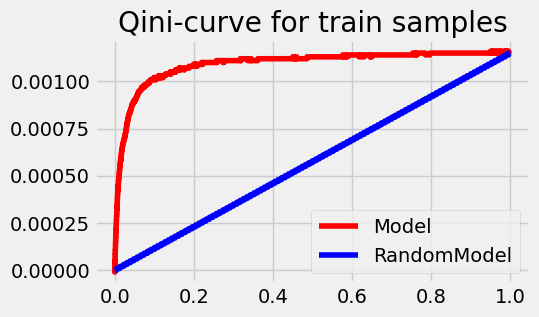

Qini score: 4333.521


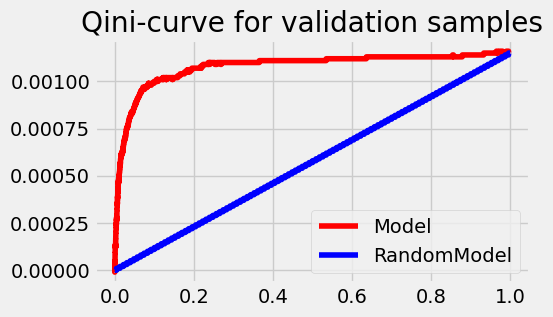

Qini score: 1406.690


In [41]:
# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = r_learner.predict(np.array(data_train[feature].values.copy()))
data_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на валидационной выборке
uplift_vals = r_learner.predict(np.array(data_val[feature].values.copy()))
data_val['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(data_train, title='train')
qini_df(data_val, title='validation')


**Вывод:** Результаты R-learner практически аналогичны X-learner

## 7. Построение UpliftRandomForest. Оцененка качества с помощью qini curve.

In [40]:
# Создаем простое дерево.
uplift_forest = UpliftRandomForestClassifier(
    n_estimators=100, max_depth=5, min_samples_leaf=200, 
    min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', 
    control_name='0', random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_forest.fit(
    data_train[feature].values,
    treatment=data_train[treatmen].apply(str).values,
    y=data_train[target].values
)

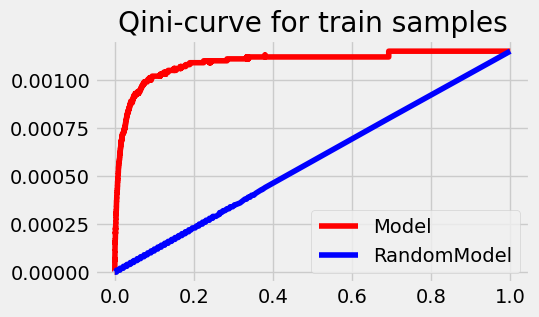

Qini score: 4343.653


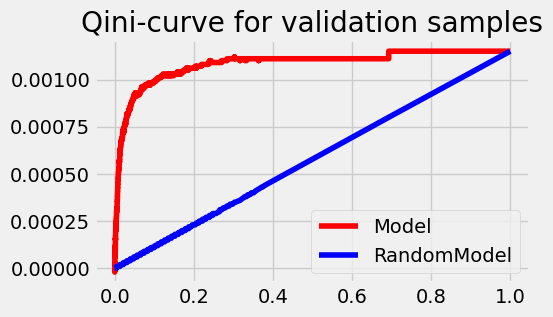

Qini score: 1415.959


In [42]:
# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(data_train[feature].values.copy()))
data_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на валидационной выборке
uplift_vals = uplift_forest.predict(np.array(data_val[feature].values.copy()))
data_val['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(data_train, title='train')
qini_df(data_val, title='validation')

**Вывод:** Результаты uplift_forest практически аналогичны X-learner и r-learner.

## 8. Вывод о том, какие модели лучше использовать в этом бизнес-кейсе.


 s_learner


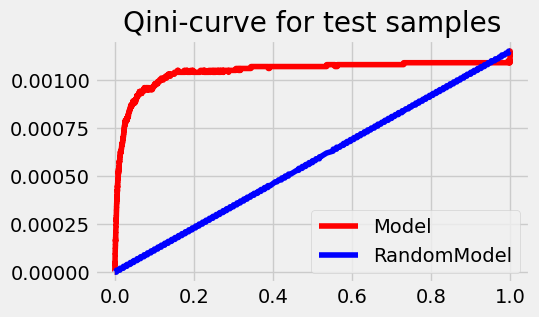

Qini score: 1310.256

 t_learner


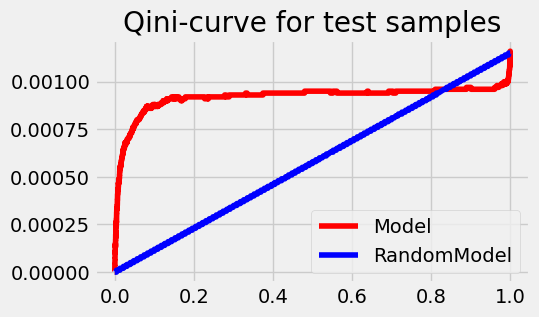

Qini score: 960.291

 x_learner


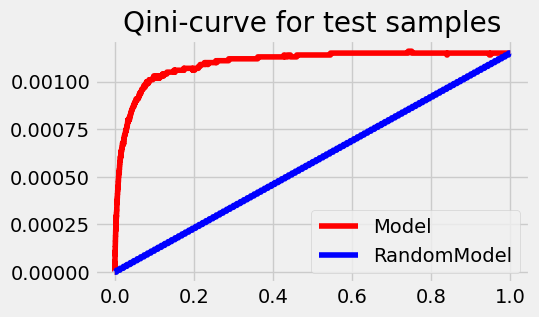

Qini score: 1458.897

 r_learner


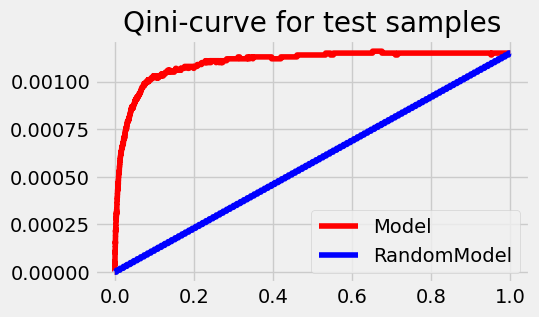

Qini score: 1463.330

 uplift_forest


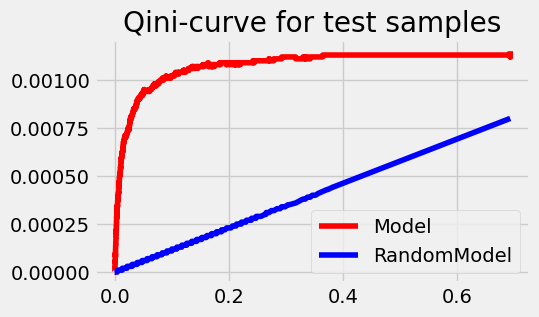

Qini score: 1450.967


In [43]:
# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(np.array(data_test[feature].values.copy()))
data_test['uplift_score'] = uplift_vals
print('\n s_learner')
qini_df(data_test, title='test')

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = t_learner.predict(np.array(data_test[feature].values.copy()))
data_test['uplift_score'] = uplift_vals
print('\n t_learner')
qini_df(data_test, title='test')

# # Сделаем предсказание uplift-эффекта на тестовой выборке
p=np.array([0.5 for i in range(len(data_test[feature]))])
uplift_vals = x_learner.predict(np.array(data_test[feature].values.copy()), p=p)
data_test['uplift_score'] = uplift_vals
print('\n x_learner')
qini_df(data_test, title='test')

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = r_learner.predict(np.array(data_test[feature].values.copy()))
data_test['uplift_score'] = uplift_vals
print('\n r_learner')
qini_df(data_test, title='test')

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(data_test[feature].values.copy()))
data_test['uplift_score'] = uplift_vals
print('\n uplift_forest')
qini_df(data_test, title='test')

**Вывод:** Исходя из предсказаных результатов на тестовой выбокре можно сказать что результаты, получанные на валидационной выборке являются корректными. Примерно одинаковые метрики на тестовой и валидационной выборке показали модели на x_learner, r_learner и uplift_forest.   
Результаты полученые на t-learner свидетельствуют о том, что используемая модель переобучена. Возможно при использовании другой модели результыты были бы выше.